In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import value_iteration.environments.thread_the_needle as e
import matplotlib.pyplot as plt
import value_iteration.models.utils
import numpy as np
import pandas as pd
import seaborn as sns
from value_iteration.models import MCTS, GridWorldNode, ValueIterationNetwork
from value_iteration.models.utils import softmax
from tqdm import tqdm


# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

sparse_diffusion_matrix = e.make_diffision_transition_matrix(
    n_rows, n_columns, sparse=False
)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0
R[n_columns - 1] = 1.0
R[-1] = 1.0
R[-n_columns] = 1.0

gamma = 0.8
iterations = 10

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions=[sparse_diffusion_matrix],
    reward_functions=[R],
    n_rows=n_rows,
    n_columns=n_columns,
    gamma=gamma,
    iterations=iterations,
    return_interim_estimates=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

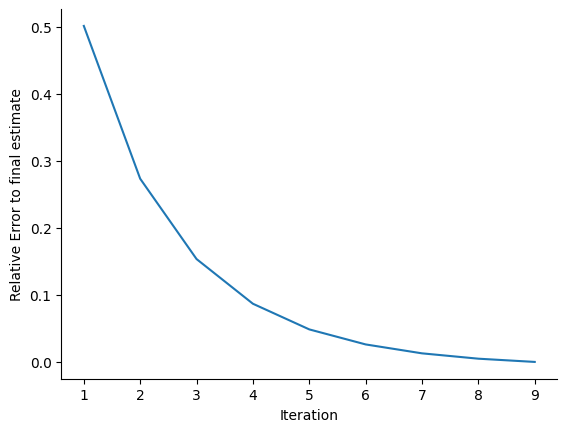

In [3]:
error = np.linalg.norm(V - np.tile(V[-1, :], (iterations, 1)), axis=1)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel("Relative Error to final estimate")
plt.xlabel("Iteration")
sns.despine()

Text(0.5, 1.0, 'First value estimate')

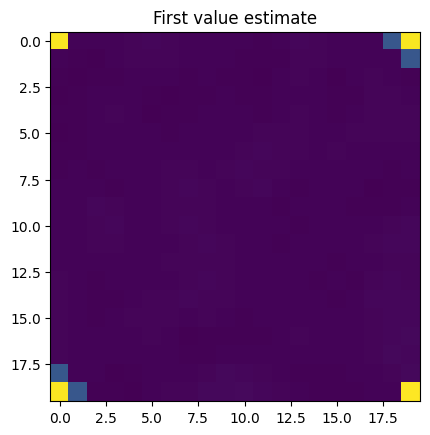

In [4]:
plt.imshow(V[0, :].reshape(grid_shape), cmap="viridis")
plt.title("First value estimate")
# plt.savefig('images/2dDrift_v0.pdf', dpi=300)

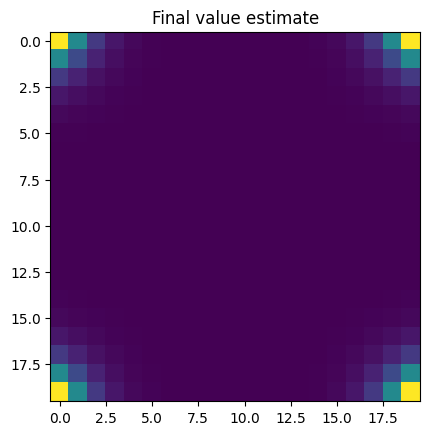

In [5]:
plt.title("Final value estimate")
plt.imshow(V[-1, :].reshape(grid_shape), cmap="viridis", vmin=0, vmax=1)
# plt.savefig('images/2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

In [6]:
# define the enviornment
n_rows, n_columns = 1, 20

sparse_diffusion_matrix = e.make_diffision_transition_matrix(
    n_rows, n_columns, sparse=False
)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0

iterations = 10000


# helper function
def plot_1d_value_estimates(value_estimates, gamma, ax=None, legend=True):
    if ax is None:
        _, ax = plt.subplots()

    n_steps = 7
    cc = sns.color_palette("viridis_r", n_colors=n_steps)
    for ii in range(0, n_steps):
        ax.plot(value_estimates[2**ii, :], label=f"{2**ii}", c=cc[ii])
    ax.plot(value_estimates[-1, :], label=f"10,000", c="k", ls="--")
    ax.set_ylabel("Estimated Value")
    ax.set_xlabel("Distance from left edge")
    if legend:
        ax.legend(title="Iteration")
    ax.set_title(r"$\gamma={}$".format(gamma))
    ax.set_xticks([ii for ii in range(0, n_columns + 1, 4)])


#     sns.despine(trim=True)


def value_estimate_error(value_estimates):
    return np.linalg.norm(
        value_estimates[:-1:] - np.tile(value_estimates[-1, :], (iterations - 1, 1)),
        axis=1,
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

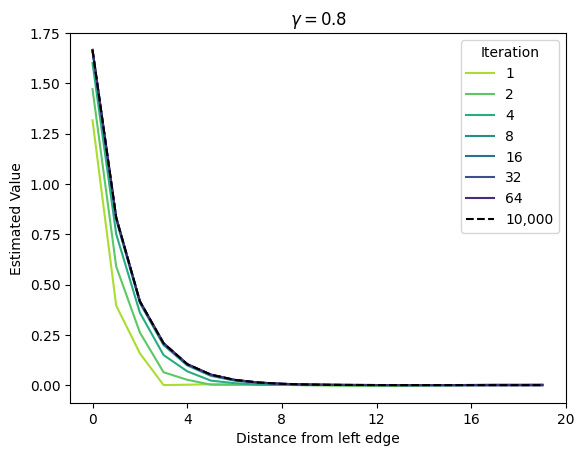

In [7]:
gamma = 0.8

# call the value iteration network
Q, V_g80 = ValueIterationNetwork.value_iteration(
    transition_functions=[sparse_diffusion_matrix],
    reward_functions=[R],
    n_rows=n_rows,
    n_columns=n_columns,
    gamma=gamma,
    iterations=iterations,
    return_interim_estimates=True,
)

error_g08 = value_estimate_error(V_g80)

plot_1d_value_estimates(V_g80, gamma)
# plt.savefig('images/1dDrift_g8.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

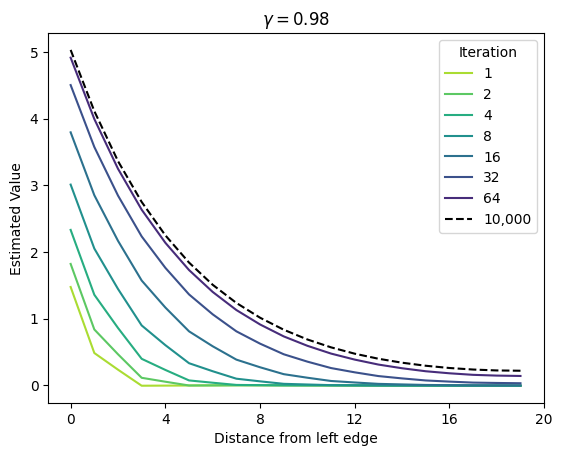

In [8]:
gamma = 0.98

# call the value iteration network
Q, V_g98 = ValueIterationNetwork.value_iteration(
    transition_functions=[sparse_diffusion_matrix],
    reward_functions=[R],
    n_rows=n_rows,
    n_columns=n_columns,
    gamma=gamma,
    iterations=iterations,
    return_interim_estimates=True,
)

error_g098 = value_estimate_error(V_g98)

plot_1d_value_estimates(V_g98, gamma)
# plt.savefig('images/1dDrift_g98.pdf', dpi=300)

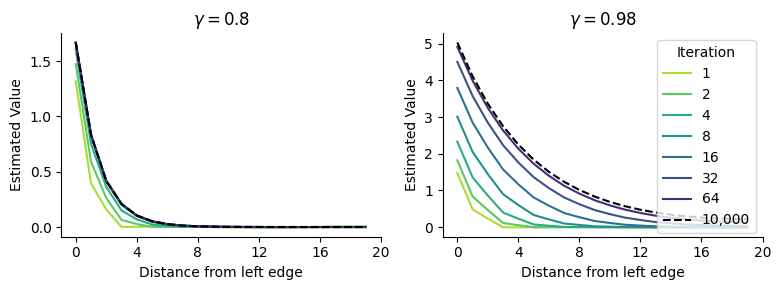

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
plot_1d_value_estimates(V_g80, 0.80, ax=axes[0], legend=False)
plot_1d_value_estimates(V_g98, 0.98, ax=axes[1], legend=True)
sns.despine()
plt.tight_layout()
plt.savefig(
    "images/1D-statespace.pdf",
    dpi=300,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

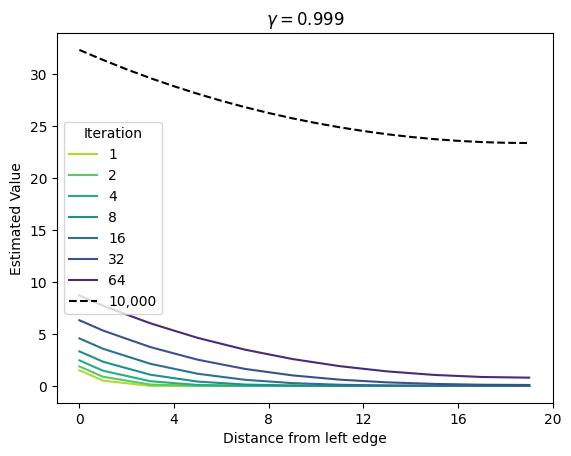

In [10]:
gamma = 0.999

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions=[sparse_diffusion_matrix],
    reward_functions=[R],
    n_rows=n_rows,
    n_columns=n_columns,
    gamma=gamma,
    iterations=iterations,
    return_interim_estimates=True,
)

error_g0999 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
# plt.savefig('images/1dDrift_g999.pdf', dpi=300)

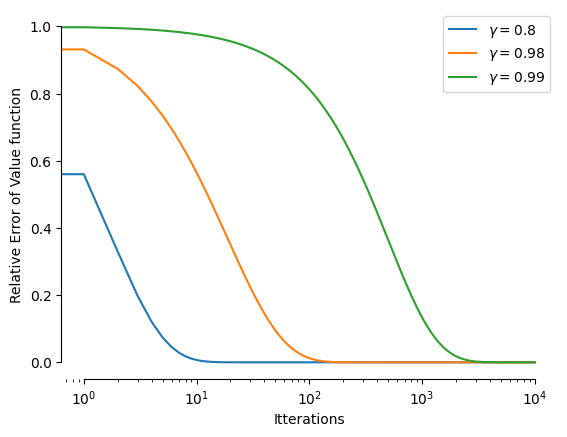

In [11]:
plt.plot(error_g08 / np.max(error_g08), label=r"$\gamma = {}$".format(0.8))
plt.plot(error_g098 / np.max(error_g098), label=r"$\gamma = {}$".format(0.98))
plt.plot(error_g0999 / np.max(error_g0999), label=r"$\gamma = {}$".format(0.99))
plt.xscale("log")
plt.legend()
plt.xlabel("Itterations")
plt.ylabel("Relative Error of Value function")
sns.despine(trim=True)
plt.savefig("images/convergence_as_function_of_gamma.pdf", dpi=300)

In [12]:
# error = simulation_utils.evaluate_policy(mcts.get_selection_policy(beta=4), optimal_policy)


# fig, ax = plt.subplots(figsize=(12, 8))
# pos  = ax.imshow(error.reshape(1, -1), cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
# plt.plot(5, 0, '*', c='r', markersize=8)
# environments.clean_up_reward_at_end(plt.gca(), n_columns)
# plt.show()

## Visualization: Adjacency Matrix
2-d lattice grid-world with 16 states




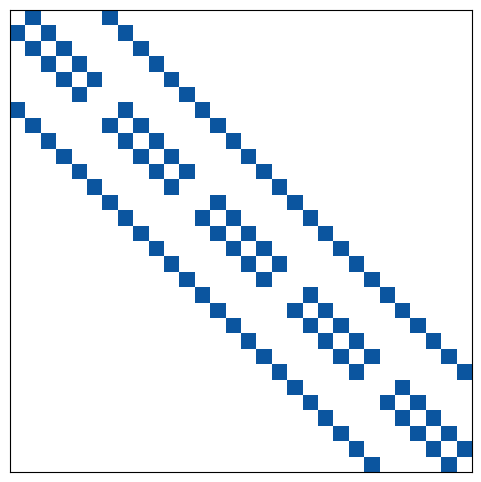

In [13]:
n_rows, n_columns = 5, 6
transition_functions = e.make_diffision_transition_matrix(n_rows, n_columns, False)

# conver to adjacency matrix
import matplotlib

transition_functions = transition_functions > 1e-3

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(
    transition_functions,
    cmap=matplotlib.colors.ListedColormap(["White"] + sns.color_palette("Blues")),
    vmin=0,
)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig("images/5x6adjacency.pdf", dpi=300)

## Example 4: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


In [14]:
# define the enviornment
n_rows, n_columns = 20, 20
movement_penalty = 0
slip_probability = 0.05
random_movement_on_error = False

transition_functions, state_reward_function, optimal_policy = e.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=movement_penalty,
    slip_probability=slip_probability,
    random_movement_on_error=random_movement_on_error,
    sparse=False,
)


state_action_reward_functions = e.get_state_action_reward_from_sucessor_rewards(
    state_reward_function, transition_functions
)


grid_shape = (n_rows, n_columns)

goal_state = 0
bottleneck_start_state = n_rows * n_columns - n_columns // 2
corner_start_state = n_rows * n_columns - 1

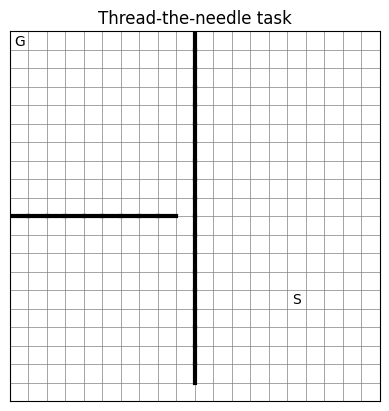

In [15]:
plt.imshow(np.zeros((n_rows, n_columns)), cmap="Greys")
e.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

plt.gca().annotate("G", (0, 0), ha="center", va="center", c="k")
plt.gca().annotate("S", (n_rows - 5, n_columns - 6), ha="center", va="center", c="k")
plt.title("Thread-the-needle task")
plt.savefig("images/thread_the_needle_task.png", dpi=300)

### Value Iteration

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

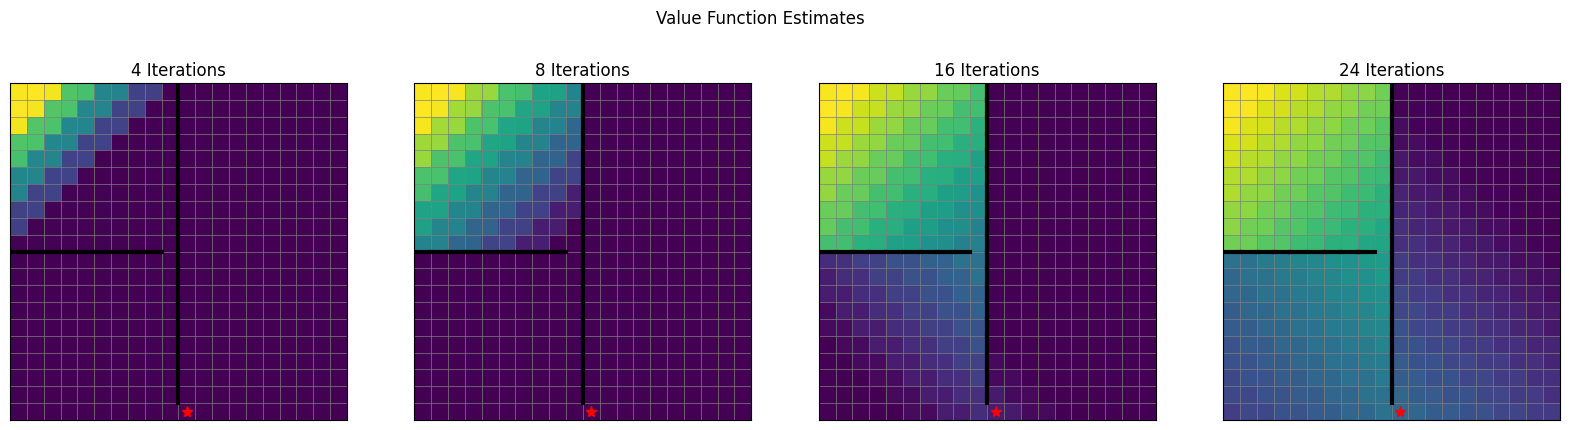

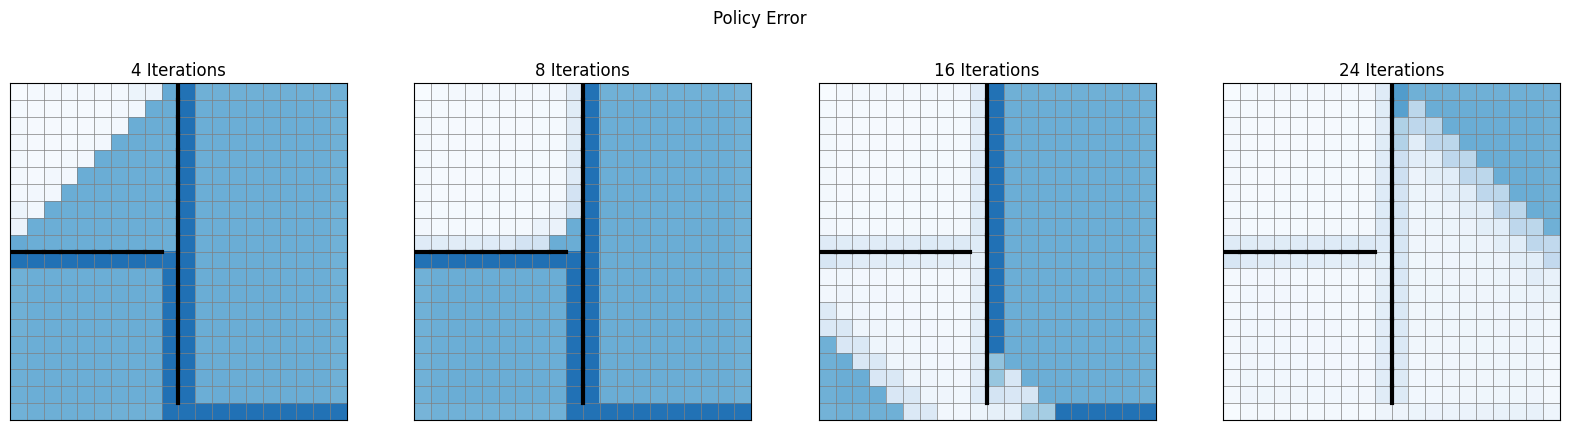

In [16]:
gamma = 0.99
beta = 5

common_model_kwargs = dict(
    transition_functions=transition_functions,
    reward_functions=state_action_reward_functions,
    n_rows=n_rows,
    n_columns=n_columns,
)


fig_v, axes_v = plt.subplots(1, 4, figsize=(20, 5))
fig_e, axes_e = plt.subplots(1, 4, figsize=(20, 5))


# 1 iteration
def evalute_plot_vi(iterations, ax_v, ax_e):
    Q, R = ValueIterationNetwork.value_iteration(
        gamma=gamma, **common_model_kwargs, iterations=iterations
    )
    pi = softmax(Q, beta=beta)
    error = value_iteration.models.utils.evaluate_policy(
        pi, optimal_policy=optimal_policy
    )

    ax_v.imshow(R.reshape(n_rows, n_columns))

    r, c = e.GridWorld.get_position_from_state(bottleneck_start_state, n_columns)
    ax_v.plot(c, r, "*", c="r", markersize=8)
    e.clean_up_thread_the_needle_plot(ax_v, n_columns, n_rows)
    ax_v.set_title(f"{iterations} Iterations")

    pos = ax_e.imshow(
        error.reshape(grid_shape),
        cmap=sns.color_palette("Blues", as_cmap=True),
        vmin=0,
        vmax=1,
    )
    e.clean_up_thread_the_needle_plot(ax_e, n_columns, n_rows)
    ax_e.set_title(f"{iterations} Iterations")


evalute_plot_vi(4, axes_v[0], axes_e[0])
evalute_plot_vi(8, axes_v[1], axes_e[1])
evalute_plot_vi(16, axes_v[2], axes_e[2])
evalute_plot_vi(24, axes_v[3], axes_e[3])

fig_v.suptitle("Value Function Estimates")
fig_e.suptitle("Policy Error")

fig_v.savefig("images/thread_the_needle_value_function.png", dpi=300)
fig_e.savefig("images/thread_the_needle_policy_error.png", dpi=300)